# Cell growth on the standard model for a bioreactor (product excluded)
The goal is to use a simple DGL that displays the characteristic behavior for Substrate consumption and Biomass growth for Data, then train a NN, DMD, or a gaussian Model with it. Afterwards, some values (e.g in the growth rate $\mu(S)$-the Km-value) are in the DGL are changed to generate a new output for the Biomass. Then it is attempted to design an observer, that can make the (now flawed) model converge to the real states.

The system of DGLs that will be used here is :
$$
\begin{aligned}
\dot{b} &= -Db + \rho(s)b \\
\dot{s} &= D(s_e - s) - \rho(s)b
\end{aligned}
$$
with the biomass being the measured output, so that 
$$y(t)=b(t)$$ 



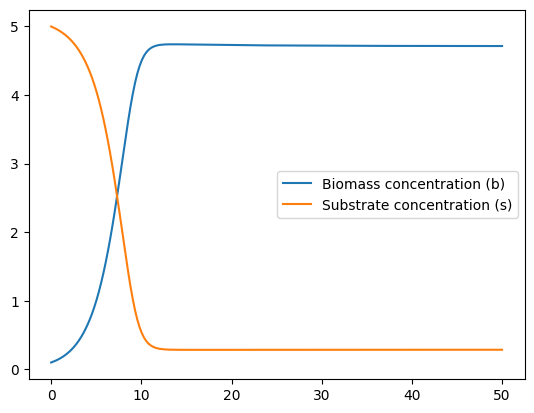

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import helperfunctions as hf


def Biosystem(t, y, D, K_m, s_e, mu_max):
    b, s = y
    rho = mu_max * s / (K_m + s)
    dbdt = -D * b + rho * b
    dsdt = D * (s_e - s) - rho * b
    return [dbdt, dsdt]


# Initial conditions
y0 = [0.1, 5.0]

# Time span
t_span = (0, 50)
t_eval = np.linspace(*t_span, 200)

# Parameter values
D = 0.1         # Dilution rate
K_m = 2          # Monod-constant
s_e = 5         # External substrate concentration
mu_max = 0.8       # Maximum specific growth rate

# Solve ODE
sol = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)

plt.plot(sol.t,sol.y[0], label='Biomass concentration (b)')
plt.plot(sol.t, sol.y[1], label='Substrate concentration (s)')
plt.legend( loc='best')
plt.show()


# <u> **1. Models** </u>

# <u> Neural Network setup and traing Data </u>

In [2]:
#creating and storing more datasets with the same parameters but different initial conditions

Dataset={}
#number of datasets=j
j=10
for i in range (0,j):
    y0 = [0.1 + i * 0.5, 5.0 - i * 0.5]  # Varying initial conditions
    sol_i = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
    Dataset[f'B{i}'] = sol_i.y[0]
    Dataset[f'S{i}'] = sol_i.y[1]



import torch as torch
import torch.nn as nn

#initializing the neural network class that inherits from nn
dim=2                           #b and s
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),              
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dim)      
        )
    def forward(self, x):
        return self.model(x)
    
model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells


for i in range (0,j):
    X_tensor = torch.tensor(np.array([Dataset[f'B{i}'][:-1],Dataset[f'S{i}'][:-1]]).T, dtype=torch.float32)
    # print(X_tensor.shape)#199 batch with dim 2

    Y_tensor = torch.tensor(np.array([Dataset[f'B{i}'][1:],Dataset[f'S{i}'][1:]]).T, dtype=torch.float32)
    # print(Y_tensor.shape)#199,2

    for epoch in range(i*100,100+i*100):  # Training for 100 epochs per dataset
        optimizer.zero_grad()
        output = model(X_tensor)        #calls the forward function of the Neural Network class
        loss = criterion(output, Y_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 12.416118
Epoch 100, Loss: 0.001807
Epoch 200, Loss: 0.000348
Epoch 300, Loss: 0.000194
Epoch 400, Loss: 0.000121
Epoch 500, Loss: 0.000073
Epoch 600, Loss: 0.000040
Epoch 700, Loss: 0.000023
Epoch 800, Loss: 0.000015
Epoch 900, Loss: 0.000004


# Validation of the NN with different initial conditions
 
it can be observed, that there is definitely a mismatch between the real trajectory and the predicted trajectory.
-->Checking whether an Observer can help to get the real states of the system, even with wrong initial guess


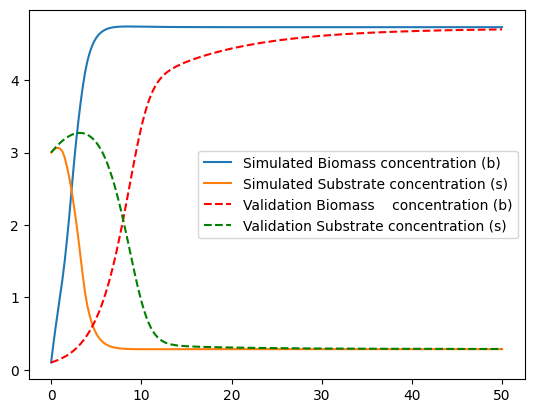

In [3]:
y0=[0.1,3] #initial conditions for the validation with the neural network
# K_m=1
validation=solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
Dataset_val = {}
Dataset_val['B1'] = validation.y[0]
Dataset_val['S1'] = validation.y[1]

##NN simulation
sol_sim=[[0.1,3]]
for i in range (0, len(t_eval)-1):
    sol_prev=sol_sim[i]
    ni=model(torch.tensor(sol_prev,dtype=torch.float32)).detach().numpy()
    sol_sim.append(ni)
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')

# <u> DMD and Hankel DMD </u>
Another Data based modeling approach is using the "Dynamic mode Decomposition", where the data is used to find a best fit linear operator for the approximation of the nonlinear system such that
$$x_{k+1}=A\cdot x_{k}$$

The practical computation uses the singular value decomposition of the snapshot matrices  
SVD of $X = U \Sigma V^T$ and $X' = A X = A U \Sigma V^T$

To solve for $A$, use the pseudoinverse:
$$
A = X' V \Sigma^{-1} U^T
$$

Where:
- $X = [x_1, ..., x_{m-1}]$ (data matrix of snapshots)
- $X' = [x_2, ..., x_m]$ (data matrix shifted by one step)
- $U, \Sigma, V^T$ are from the SVD of $X$.

This gives the best-fit linear operator $A$ such that $x_{k+1} \approx A x_k$.

If it were the case that the system dimension was very large, then the Matrix $A (dim=n\times n$) would also be very large, thus increasing the computational load siginificantly. Then, it would be reasonable to use a reduced order System.
In our case however, the system Dimension is 2, thus the matrix A is of dimension $2 \times 2$. So this won't be necessary.

However the low dimensionality might lead to another Problem :

---

### Potential Problems: 

Usually the Data-vector is of high dimension. in our case it only has Dimension 2. This means that $A \in 2\times2$ which might not be sufficient to correctly approximate the Nonlinear Dynamics. If that should be the case, we could also look at so called **Hankel DMD's**
Hankel DMDs split the Datavector and  stack the segments  (each shifted by one time index) on top of each other to increase the dimension of the System. 

---

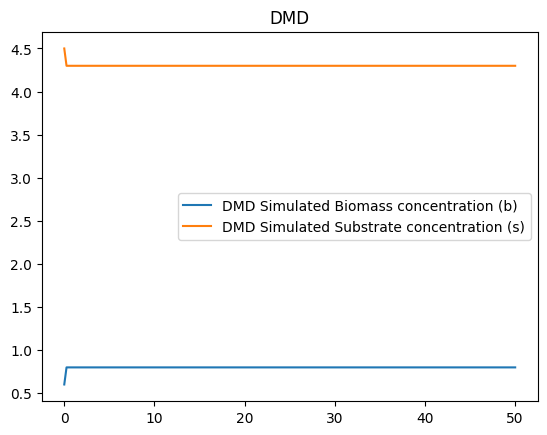

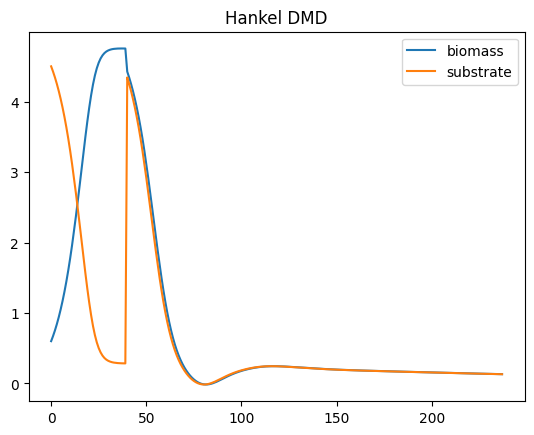

In [4]:
#DMD of the simulated Dataset
X = np.array([Dataset['B1'][:-1], Dataset['S1'][:-1]])
Xp=np.array([Dataset['B1'][1:], Dataset['S1'][1:]])
A,_,_,_ = hf.compute_DMD(X, Xp)
dim=2           #dimension of our system

#now i want to check whether the DMD matrix can predict the next step on the same dataset 
x0 = np.array([Dataset['B1'][0], Dataset['S1'][0]])
for i in range (0, len(t_eval)):
    xi=A@x0
    if i==0:
        sol_dmd=[x0]
    else:
        sol_dmd.append(xi)


# print(np.array(sol_dmd).shape)
plt.plot(t_eval, np.array(sol_dmd)[:, 0], label='DMD Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_dmd)[:, 1], label='DMD Simulated Substrate concentration (s)')
plt.title('DMD')
plt.legend()
plt.show()
#As we can see the system is not really capturing the dynamics of the system, so we can attempt the Hankel DMD
#-------------------------------------Hankel DMD------------------------------------

num_columns=8                                      #number of colums to build DMD with
#i dont stack the full matrix, but only up to the 10th column, because if i use the whole snapshot i would already have all the data i need. 
N_snapshots=40
A_hankel,_,_,_ = hf.compute_hankel_DMD(X[:,:N_snapshots], Xp[:,:N_snapshots], cols=num_columns)

#now i want to check whether the Hankel DMD matrix can predict the next step on the same dataset
x0H=hf. stack_snapshots(X=X[:,:N_snapshots], cols=num_columns)
xkH=x0H
sol_hankel=[hf.unstack_snapshots(xkH,dim)]     #so x0,x1,x2...x9 are in here when starting, and i only append the last entry of the Xp to it 
for i in range (1,199):
    xkH=A_hankel@xkH
    sol_hankel.append(hf.unstack_snapshots(xkH,dim)[-1,:])
    

#sol_hankel currently looks like this :[[dim2xsnapshots],[2x1],[2x1]...]-->into matrix
sol_hankel = np.array([
    np.hstack([mat[0] for mat in sol_hankel]),  # Stack all first rows
    np.hstack([mat[1] for mat in sol_hankel])   # Stack all second rows
])
# print(xkH.shape)
plt.plot(sol_hankel[0,:],label='biomass')
plt.plot(sol_hankel[1,:],label='substrate')
plt.legend(loc='best')
plt.title('Hankel DMD')
plt.show()

i assume the Hankel DMD does not have enough datapoints to accurately display the dynamics. The substrate should not be increasing at all in this constellation. Thus, i assume the DMD is not really suitable for systems of this order. Usually, when applying DMD a huge datavector for each timestep is provided, sometimes up to 1000 values per timestep. Then a DMD is computed and the system order may be reduced to lower computational load, while still capturing the dynamics. In our case however the low system order seems to cause Problems, as even when stacking the values there only is a relatively low amount of values to use for DMD.

# <u> Gaussian Processes </u> 
The best visual and easy to understand explanation i could find was here:

[Gaussian_Process_not_quite_for_dummies](https://thegradient.pub/gaussian-process-not-quite-for-dummies/)


For many ML-Models, providing an input simply offers you the output as a point/vector.  
GPs however provide a **distribution** to reflect **uncertainties** in the prediction.

The basic idea is putting a distribution over the set of all possible **smooth functions** for the dataset, with the assumption that the output of the set of input points follows a **joint Gaussian distribution**:
$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$


Where:  
- $m(x) = \mathbb{E}[f(x)]$ is the **mean function** (often assumed to be 0)  
- $k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))] $ is the **kernel (covariance function)**

---

### Important factors:

- The **Kernel** is a function which measures the **similarity (or correlation)** between two input points.  
  It defines the **covariance structure** of the Gaussian Process and encodes assumptions about the function being modeled, such as periodicity, or linearity.

- Common kernels are **Radial Basis Function (RBF)** and **Linear kernels**. For example, the RBF kernel:

$$k(x, x') = \sigma_f^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)$$

- The choice of kernel has a **significant impact** on the GP's predictions and its ability to capture the underlying data patterns.

- Often, **hyperparameters** (like $ \ell$, $ \sigma_f $) must be tuned to produce the best result.

---

## GP Regression Prediction

Given a joint Gaussian:

$$
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix}
\sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0
\end{bmatrix},
\begin{bmatrix}
A & B \\
B^\top & C
\end{bmatrix}
\right)
$$

The conditional distribution of $y_1$ given $y_2$ is:

$$
y_1 \mid y_2 \sim \mathcal{N}(BC^{-1}y_2,\; A - BC^{-1}B^\top)
$$
with $y_1$ being the estimated states and $y_2$ being the points for which there are measurements.

Where the covariance matrices are computed from the kernel function $k(x, x')$ as:

- $A = k(X_1, X_1)$  
- $B = k(X_1, X_2)$  
- $C = k(X_2, X_2) + \sigma^2 I$  (if observations are noisy)

$X_1$ is the set of points in the input space for which the output is to be estimated , and $X_2$ is the set of points in the input space for which there are measurements available.



  

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   2.743964e+02   2.321219e+04 
    00s07  0009  -2.889164e+03   7.207181e+02 
    00s15  0019  -2.898115e+03   5.505675e-02 
    00s19  0024  -2.898205e+03   9.063434e-02 
    00s19  0025  -2.898207e+03   2.904279e-03 
    00s59  0086  -2.898210e+03   2.279277e-04 
Runtime:     00s59
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH


Name : GP regression
Objective : -2898.210237196354
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     3.8998562380636064  |      +ve      |        
  rbf.lengthscale          |     1.5206818384910095  |      +ve      |        
  Gaussian_noise.variance  |  6.702132196700441e-15  |      +ve      |        


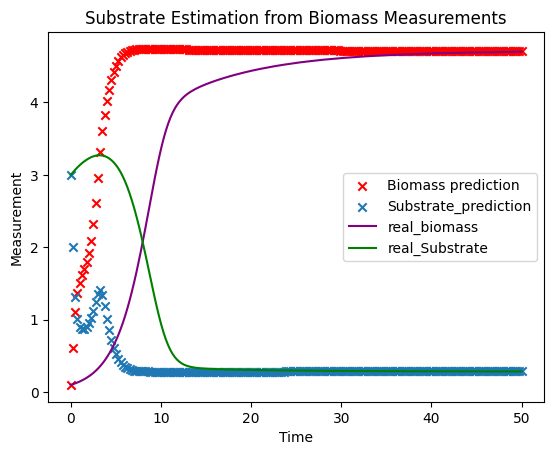

In [5]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
#TODO: make the prediction iterative, so that i dont need to pass 1xlen(t_eval) as input but rather maybe a 1x1 for the initial biomass and then loop through the time...

# Generate synthetic data (replace with your actual data)
# np.random.seed(42)
time = t_eval.reshape(-1, 1) if t_eval.ndim == 1 else t_eval  # Ensure [n_samples, 1]
biomass = Dataset['B0'].reshape(-1, 1) 
substrate = Dataset['S0'].reshape(-1, 1)

# Training data - both biomass and substrate known
X_train = np.hstack([biomass[:-1],substrate[:-1]])  # Input: [time, biomass,substrate]
Y_train = np.hstack([biomass[1:],substrate[1:]])  # Output: substrate

# 1. Train the GP model
kernelrbf = GPy.kern.RBF(input_dim=2, active_dims=[0,1], ARD=False)  # ARD for automatic relevance determination-->learns seperate lenght scales (parameter l in RBF equation for smoothness of curve )
# kernelexp =  GPy.kern.Linear(input_dim=2, active_dims=[0,1],ARD=True)

kernel=kernelrbf
m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

print(m)  # Show optimized model parameters

# 2. Make predictions with new biomass measurements
# New observations - only biomass known 
n_steps = len(t_eval)
bm = np.zeros(n_steps)
sm = np.zeros(n_steps)

# Initial values
bm[0] = Dataset_val['B1'][0]
sm[0] = Dataset_val['S1'][0]


for t in range(1, n_steps):
    X_input = np.array([[bm[t-1], sm[t-1]]])
    pred, _ = m.predict(X_input)
    bm[t] = pred[0, 0]    # predicted biomass-->pred is [[b,s]] so pred[0][0] is b
    sm[t] = pred[0, 1]    # predicted substrate


# Plot substrate predictions
plt.scatter(t_eval, bm, marker='x',color='r', label='Biomass prediction')
plt.scatter(t_eval,sm,marker='x',label='Substrate_prediction')
plt.plot(t_eval,Dataset_val['B1'],label='real_biomass', color='purple')
plt.plot(t_eval,Dataset_val['S1'],label='real_Substrate',color='green')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Substrate Estimation from Biomass Measurements')
plt.legend()
plt.show()

# <u> **Observer** </u>

# <u> Unscented Kalman Filter</u>
In this section it will be attempted to use an Unscented Kalman Filter to account for the wrong initial guess of the Substrate concentration.

The key idea of the UFK is to take sample points around the mean of a gaussian variable and then propagate it through the Neural Network (not the DMD, since the DMD didnt seem to be suited to capture these dynamics), thus using the real model for the dynamics rather than a jacobian. In doing so, the weights attached to the sigma points help to capture the mean and the covariance of the distribution without actual analytical equations of the system dynamics.

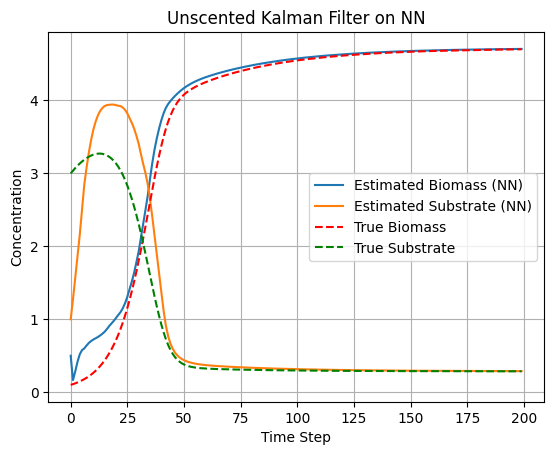

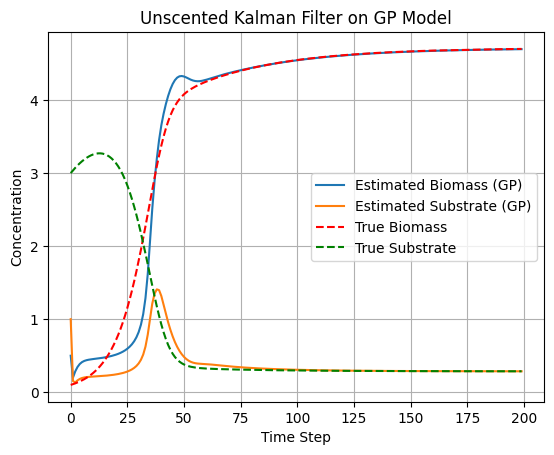

In [6]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import numpy as np
import torch
import matplotlib.pyplot as plt

# simulation time is t_eval (which was about 50 seconds i think)

def f_NN(x, dt):
    """State transition function using the neural network. f(x(t)) = x(t+1)"""
    x_tensor = torch.tensor(x, dtype=torch.float32)
    return model(x_tensor).detach().numpy()

def h(x):
    """Measurement function, in this case only the biomass concentration is measured."""
    return np.array([x[0]])

def GP(x, dt):
    """State transition function using GP with time as part of the state."""
    b,s=x
    X_input = np.array([[b, s]])
    pred, _ = m.predict(X_input)
    return np.array([pred[0]])  # advance time, use GP to predict [b, s]

# State dimension: 2 (b, s)
# Measurement dimension: 1 (b)
dim_x_NN = 2
dim_z = 1
dim_x_GP = 2  # depends on whether you want to include time...

# Create sigma points object
"""As suggested in the documentation 
-alpha is the "spread of the sigma points around the mean state, values between 0 and 1 are common
-beta affects the weight of the central sigma point, typically set to 2 for Gaussian distributions
-kappa is a secondary scaling parameter, often set to 0 for simplicity."""
points_NN = MerweScaledSigmaPoints(n=dim_x_NN, alpha=0.1, beta=2.0, kappa=0.0)
points_GP = MerweScaledSigmaPoints(n=dim_x_GP, alpha=0.1, beta=2.0, kappa=0.0)

#-------------------for the NN-----------------------------
# Create UKF object for the NN
ukf_NN = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=f_NN, hx=h, dt=1.0, points=points_NN)
ukf_GP = UKF(dim_x=dim_x_GP, dim_z=dim_z, fx=GP, hx=h, dt=1.0, points=points_GP)

# Initial state guess (e.g., wrong s value)
ukf_NN.x = np.array([0.5, 1])        # Initial guess for [b, s] the real values are [0.1, 3]
ukf_GP.x = np.array([0.5, 1])   # Initial guess for [b, s]

# Initial covariance (uncertainty in state)
ukf_NN.P = np.eye(dim_x_NN) * 0.1  # You can tune this
ukf_GP.P = np.eye(dim_x_GP) * 0.1  # Adjusted for correct dimension

# Process noise (model uncertainty)
ukf_NN.Q = np.diag([1e-3, 1e-3])         # Tune this based on how inaccurate your NN is
ukf_GP.Q = np.diag([1e-3, 1e-3])   # Small uncertainty for time, more for b and s

# Measurement noise (e.g., sensor error in b, but i should not have any noise since i simulated with the ODE for the measurement)
ukf_NN.R = np.array([[0.01]])  # Measurement noise variance
ukf_GP.R = np.array([[0.01]])  # Match NN

b_measurements = Dataset_val['B1'][0:]  # Use the biomass measurements for updating the filter

estimated_states_NN = [ukf_NN.x.copy()]  # Store the initial state (used for plotting)
estimated_states_GP = [ukf_GP.x.copy()]

# Apply UKF for each measurement
for z in b_measurements[1:]:  # Skip the first measurement since i assume the measurement is not available at t=0
    ukf_NN.predict()
    ukf_NN.update(np.array([z]))
    estimated_states_NN.append(ukf_NN.x.copy())

    ukf_GP.predict()
    ukf_GP.update(np.array([z]))
    estimated_states_GP.append(ukf_GP.x.copy())

#--------------------- Plotting Section ---------------------------

#NN results
estimated_states_NN = np.array(estimated_states_NN)
plt.figure()
plt.title('Unscented Kalman Filter on NN')
plt.plot(estimated_states_NN[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_NN[:, 1], label='Estimated Substrate (NN)')
plt.plot(validation.y[0], 'r--', label='True Biomass')
plt.plot(validation.y[1], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#GP-based UKF results
estimated_states_GP = np.array(estimated_states_GP)
plt.figure()
plt.title('Unscented Kalman Filter on GP Model')
plt.plot(estimated_states_GP[:, 0], label='Estimated Biomass (GP)')
plt.plot(estimated_states_GP[:, 1], label='Estimated Substrate (GP)')
plt.plot(validation.y[0], 'r--', label='True Biomass')
plt.plot(validation.y[1], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()
